In [32]:
!pip install -q transformers datasets openpyxl scikit-learn seaborn joblib pandas lifelines

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
base_path = "/kaggle/input/nkr-iknl-breast-syntheticdata"

In [34]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from lifelines.utils import concordance_index
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             mean_squared_error, r2_score, mean_absolute_error, brier_score_loss)
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
from datasets import Dataset
import joblib
from joblib import Parallel, delayed
import gc
from scipy import stats

In [35]:
sns.set(style="whitegrid")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [36]:
def apply_days_threshold(data, num_days):
    data = data.copy()
    data['converted_from_dead'] = 0

    # Remove records where vit_stat == 0 and vit_stat_int < num_days
    condition_remove = (data['vit_stat'] == 0) & (data['vit_stat_int'] < num_days)
    data = data[~condition_remove]

    # Convert records where vit_stat == 1 and vit_stat_int > num_days to vit_stat == 0
    condition_convert = (data['vit_stat'] == 1) & (data['vit_stat_int'] > num_days)
    data.loc[condition_convert, 'vit_stat'] = 0
    data.loc[condition_convert, 'converted_from_dead'] = 1

    return data

In [37]:
def load_and_preprocess_data(base_path, num_days):
    data_path = os.path.join(base_path, "NKR_IKNL_breast_syntheticdata.csv")
    
    processed_classification_data_path = "/kaggle/working/processed_classification_data.csv"
    processed_regression_data_path = "/kaggle/working/processed_regression_data.csv"
    read_processed_classification_data_path = "/kaggle/working/processed_classification_data.csv"
    read_processed_regression_data_path = "/kaggle/working/processed_regression_data.csv"

    data_full = pd.read_csv(data_path, sep=';')
    data_full = data_full.drop_duplicates()

    data_full = apply_days_threshold(data_full, num_days)

    # Process Classification Data
    if os.path.exists(read_processed_classification_data_path):
        data_classification = pd.read_csv(read_processed_classification_data_path)
        if 'prompt' not in data_classification.columns:
            data_classification = generate_prompts(data_classification)
    else:
        majority_class = data_full[data_full['vit_stat'] == 0]
        minority_class = data_full[data_full['vit_stat'] == 1]

        majority_original = majority_class[majority_class['converted_from_dead'] == 0]
        majority_converted = majority_class[majority_class['converted_from_dead'] == 1]

        n_samples_needed = len(minority_class)

        majority_downsampled_list = []

        if len(majority_original) >= n_samples_needed:
            majority_downsampled = majority_original.sample(n=n_samples_needed, random_state=42)
            majority_downsampled_list.append(majority_downsampled)
        else:
            majority_downsampled_list.append(majority_original)
            n_remaining = n_samples_needed - len(majority_original)
            if n_remaining > 0:
                majority_downsampled_converted = majority_converted.sample(n=n_remaining, random_state=42)
                majority_downsampled_list.append(majority_downsampled_converted)

        majority_downsampled = pd.concat(majority_downsampled_list)

        data_classification = pd.concat([majority_downsampled, minority_class])

        data_classification = data_classification.sample(frac=1, random_state=42).reset_index(drop=True)

        data_classification = generate_prompts(data_classification)

        os.makedirs(os.path.dirname(processed_classification_data_path), exist_ok=True)
        data_classification.to_csv(processed_classification_data_path, index=False)

    # Process Regression Data
    if os.path.exists(read_processed_regression_data_path):
        data_regression = pd.read_csv(read_processed_regression_data_path)
        if 'prompt' not in data_regression.columns:
            data_regression = generate_regression_prompts(data_regression)
    else:
        data_regression = data_full[data_full['vit_stat'] == 1].reset_index(drop=True)

        data_regression = data_regression.sample(frac=1, random_state=42).reset_index(drop=True)

        data_regression = generate_regression_prompts(data_regression)

        os.makedirs(os.path.dirname(processed_regression_data_path), exist_ok=True)
        data_regression.to_csv(processed_regression_data_path, index=False)

    return data_classification, data_regression, data_full

In [38]:
def create_classification_prompt(row):
    def safe_str(value):
        return "Unknown" if pd.isnull(value) else str(value)

    prompt = f"""Patient Record:
- Age at incidence date: {safe_str(row['leeft'])}
- Gender: {safe_str(row['gesl'])}
- Year of incidence: {safe_str(row['incjr'])}
- Tumor species: {safe_str(row['tumsoort'])}
- Diagnosis basis: {safe_str(row['diag_basis'])}
- Topography excluding sub-localisation: {safe_str(row['topo'])}
- Topography including sub-localisation: {safe_str(row['topo_sublok'])}
- Lateralisation: {safe_str(row['later'])}
- Morphology: {safe_str(row['morf'])}
- Tumor behavior: {safe_str(row['gedrag'])}
- Level of differentiation: {safe_str(row['diffgrad'])}
- Clinical T (TNM): {safe_str(row['ct'])}
- Clinical N (TNM): {safe_str(row['cn'])}
- Clinical M (TNM): {safe_str(row['cm'])}
- Pathological T (TNM): {safe_str(row['pt'])}
- Pathological N (TNM): {safe_str(row['pn'])}
- Pathological M (TNM): {safe_str(row['pm'])}
- Tumor stage: {safe_str(row['stadium'])}
- Number of regional lymph nodes examined: {safe_str(row['ond_lymf'])}
- Number of positive regional lymph nodes: {safe_str(row['pos_lymf'])}
- Oestrogen receptor status: {safe_str(row['er_stat'])}
- Progesterone receptor status: {safe_str(row['pr_stat'])}
- HER2 status: {safe_str(row['her2_stat'])}
- DCIS component present: {safe_str(row['dcis_comp'])}
- Tumor size (mm): {safe_str(row['tum_afm'])}
- Sentinel node procedure result: {safe_str(row['swk_uitslag'])}
- MARI procedure result: {safe_str(row['mari_uitslag'])}
- Surgery performed: {safe_str(row['org_chir'])}
- Chemotherapy: {safe_str(row['chemo'])}
- Targeted therapy: {safe_str(row['target'])}
- Hormonal therapy: {safe_str(row['horm'])}
- Radiotherapy: {safe_str(row['rt'])}

Based on this medical record, determine the patient's vital status and the time interval since their last examination.
"""
    return prompt

In [39]:
def create_regression_prompt(row):
    def safe_str(value):
        return "Unknown" if pd.isnull(value) else str(value)

    prompt = f"""Patient Record:
- Age at incidence date: {safe_str(row['leeft'])}
- Gender: {safe_str(row['gesl'])}
- Year of incidence: {safe_str(row['incjr'])}
- Tumor species: {safe_str(row['tumsoort'])}
- Diagnosis basis: {safe_str(row['diag_basis'])}
- Topography excluding sub-localisation: {safe_str(row['topo'])}
- Topography including sub-localisation: {safe_str(row['topo_sublok'])}
- Lateralisation: {safe_str(row['later'])}
- Morphology: {safe_str(row['morf'])}
- Tumor behavior: {safe_str(row['gedrag'])}
- Level of differentiation: {safe_str(row['diffgrad'])}
- Clinical T (TNM): {safe_str(row['ct'])}
- Clinical N (TNM): {safe_str(row['cn'])}
- Clinical M (TNM): {safe_str(row['cm'])}
- Pathological T (TNM): {safe_str(row['pt'])}
- Pathological N (TNM): {safe_str(row['pn'])}
- Pathological M (TNM): {safe_str(row['pm'])}
- Tumor stage: {safe_str(row['stadium'])}
- Number of regional lymph nodes examined: {safe_str(row['ond_lymf'])}
- Number of positive regional lymph nodes: {safe_str(row['pos_lymf'])}
- Oestrogen receptor status: {safe_str(row['er_stat'])}
- Progesterone receptor status: {safe_str(row['pr_stat'])}
- HER2 status: {safe_str(row['her2_stat'])}
- DCIS component present: {safe_str(row['dcis_comp'])}
- Tumor size (mm): {safe_str(row['tum_afm'])}
- Sentinel node procedure result: {safe_str(row['swk_uitslag'])}
- MARI procedure result: {safe_str(row['mari_uitslag'])}
- Surgery performed: {safe_str(row['org_chir'])}
- Chemotherapy: {safe_str(row['chemo'])}
- Targeted therapy: {safe_str(row['target'])}
- Hormonal therapy: {safe_str(row['horm'])}
- Radiotherapy: {safe_str(row['rt'])}

Based on this medical record, determine the patient's vital status and estimate the time interval (in days) since their last examination.
"""
    return prompt

In [40]:
def generate_prompts(data):
    if 'id' in data.columns:
        data = data.drop(columns=['id'])
    data['prompt'] = data.apply(create_classification_prompt, axis=1)
    return data

In [41]:
def generate_regression_prompts(data):
    if 'id' in data.columns:
        data = data.drop(columns=['id'])
    data['prompt'] = data.apply(create_regression_prompt, axis=1)
    return data

In [42]:
def get_fold_paths(base_path, fold_number):
    fold_dir = os.path.join(base_path, "folds", f"fold_{fold_number}")
    classification_train_path = os.path.join(fold_dir, "classification_train.csv")
    classification_val_path = os.path.join(fold_dir, "classification_val.csv")
    regression_train_path = os.path.join(fold_dir, "regression_train.csv")
    regression_val_path = os.path.join(fold_dir, "regression_val.csv")
    
    return {
        'classification_train': classification_train_path,
        'classification_val': classification_val_path,
        'regression_train': regression_train_path,
        'regression_val': regression_val_path
    }

In [43]:
def initialize_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

In [44]:
def tokenize_function(examples, tokenizer, max_length=128):
    return tokenizer(
        examples['prompt'],
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

In [45]:
def prepare_classification_dataset(data, tokenizer):
    hf_dataset = Dataset.from_pandas(data[['prompt', 'vit_stat']])
    hf_dataset = hf_dataset.rename_column("vit_stat", "labels")
    hf_dataset = hf_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    hf_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    return hf_dataset

In [46]:
def prepare_regression_dataset(data, tokenizer):
    data = data.copy()
    data['vit_stat_int'] = data['vit_stat_int'].astype(np.float32)
    hf_dataset = Dataset.from_pandas(data[['prompt', 'vit_stat_int']])
    hf_dataset = hf_dataset.rename_column("vit_stat_int", "labels")
    hf_dataset = hf_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    hf_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return hf_dataset

In [47]:
def compute_metrics_classification(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)

    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    pos_probs = probs[:, 1]

    brier = brier_score_loss(labels, pos_probs)

    return {'accuracy': acc, 'brier_score': brier}

In [48]:
def train_classification_model(train_dataset, val_dataset, tokenizer, fold_number, device):
    model = AutoModelForSequenceClassification.from_pretrained(
        'dmis-lab/biobert-base-cased-v1.1',
        num_labels=2
    ).to(device)

    labels = train_dataset['labels'][:]

    training_args = TrainingArguments(
        output_dir=f'./results_classification_fold_{fold_number}',
        num_train_epochs=5,
        report_to="none",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        fp16=torch.cuda.is_available()
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_classification,
    )

    trainer.train()

    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    report = classification_report(labels, preds, output_dict=True)
    cm = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)

    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
    pos_probs = probs[:, 1]
    brier = brier_score_loss(labels, pos_probs)
    report['brier_score'] = brier

    return acc, report, cm, preds, labels, model

In [49]:
def compute_metrics_regression(p):
    preds = p.predictions.squeeze()
    labels = p.label_ids
    rmse = mean_squared_error(labels, preds, squared=False)
    mae = mean_absolute_error(labels, preds)
    r2 = r2_score(labels, preds)

    c_index = concordance_index(labels, preds, None)

    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'concordance_index': c_index}

In [50]:
def train_regression_model(train_dataset, test_dataset, tokenizer, device, base_path, fold_number=None):
    if fold_number is not None:
        model_save_path = os.path.join("../working", f"regression_model_fold_{fold_number}")
    else:
        model_save_path = os.path.join("../working", "regression_model")
    if os.path.exists(model_save_path):
        logger.info(f"Regression model for fold {fold_number} already exists. Loading from {model_save_path}.")
        model = AutoModelForSequenceClassification.from_pretrained(model_save_path).to(device)
    else:
        logger.info(f"Training regression model for fold {fold_number}.")
        model = AutoModelForSequenceClassification.from_pretrained(
            'dmis-lab/biobert-base-cased-v1.1',
            num_labels=1,
            problem_type='regression'
        ).to(device)
        training_args = TrainingArguments(
            output_dir=f'./results_regression_fold_{fold_number}',
            num_train_epochs=5,
            report_to="none",
            learning_rate=3e-5,
            weight_decay=0.01,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            evaluation_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=1,
            logging_strategy='no',
            logging_steps=0,
            logging_dir=None,
            fp16=torch.cuda.is_available()
        )
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics_regression
        )
        trainer.train()
        ensure_tensors_contiguous(model)
        model = model.to('cpu')
        os.makedirs(model_save_path, exist_ok=True)
        model.save_pretrained(model_save_path, use_safetensors=False)
        logger.info(f"Regression model for fold {fold_number} saved at {model_save_path}")
    trainer_eval = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir='./temp_eval_regression',
            per_device_eval_batch_size=8,
            report_to="none"
        ),
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_regression
    )
    predictions = trainer_eval.predict(test_dataset)
    preds = predictions.predictions.squeeze()
    labels = predictions.label_ids
    rmse = mean_squared_error(labels, preds, squared=False)
    r2 = r2_score(labels, preds)
    c_index = concordance_index(labels, preds, None)
    return rmse, r2, c_index, model

In [51]:
def ensure_tensors_contiguous(model):
    non_contiguous_params = []
    non_contiguous_buffers = []

    for name, param in model.named_parameters():
        if not param.data.is_contiguous():
            param.data = param.data.contiguous()
            if not param.data.is_contiguous():
                non_contiguous_params.append(name)

    for name, buffer in model.named_buffers():
        if not buffer.data.is_contiguous():
            buffer.data = buffer.data.contiguous()
            if not buffer.data.is_contiguous():
                non_contiguous_buffers.append(name)

    if non_contiguous_params or non_contiguous_buffers:
        error_message = "Some tensors are still non-contiguous after attempting to make them contiguous:\n"
        if non_contiguous_params:
            error_message += f"Non-contiguous Parameters: {non_contiguous_params}\n"
        if non_contiguous_buffers:
            error_message += f"Non-contiguous Buffers: {non_contiguous_buffers}\n"
        raise ValueError(error_message)
    else:
        logger.debug("All tensors are now contiguous.")

In [52]:
def save_classification_model(model, fold_number, base_path):
    ensure_tensors_contiguous(model)
    model_save_path = os.path.join("../working", f"classification_model_fold_{fold_number}")
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path, use_safetensors=False)
    logger.info(f"Saved classification model for Fold {fold_number} at {model_save_path}")

In [53]:
def save_regression_model(model, base_path):
    ensure_tensors_contiguous(model)
    model_save_path = os.path.join(base_path, "output", f"regression_model")
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path, use_safetensors=False)
    logger.info(f"Saved regression model at {model_save_path}")

In [54]:
def compute_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean = np.mean(a)
    se = stats.sem(a)
    if n < 2:
        return (mean, mean)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return (mean - h, mean + h)

In [55]:
def aggregate_metrics_with_ci(metric_list, confidence=0.95):
    mean = np.mean(metric_list)
    lower, upper = compute_confidence_interval(metric_list, confidence)
    return {'Mean': mean, 'CI Lower': lower, 'CI Upper': upper}

In [56]:
def aggregate_classification_reports_extended(reports):
    aggregated = {}
    overall_metrics = {}

    for report in reports:
        for cls, metrics in report.items():
            if isinstance(metrics, dict):
                if cls not in aggregated:
                    aggregated[cls] = {}
                    for metric, value in metrics.items():
                        aggregated[cls][metric] = []
                for metric, value in metrics.items():
                    aggregated[cls][metric].append(value)
            else:
                if cls not in overall_metrics:
                    overall_metrics[cls] = []
                overall_metrics[cls].append(metrics)

    for cls in aggregated:
        for metric in aggregated[cls]:
            aggregated[cls][metric] = np.mean(aggregated[cls][metric])

    for metric in overall_metrics:
        aggregated[metric] = np.mean(overall_metrics[metric])

    aggregated_df = pd.DataFrame(aggregated).transpose()

    return aggregated_df

In [57]:
def visualize_metrics(avg_accuracy, ci_lower_accuracy, ci_upper_accuracy,
                      brier_score, avg_c_index, ci_lower_c_index, ci_upper_c_index,
                      rmse, ci_lower_rmse, ci_upper_rmse,
                      r2, ci_lower_r2, ci_upper_r2):
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.bar(['Accuracy'], [avg_accuracy], color='skyblue',
            yerr=[[avg_accuracy - ci_lower_accuracy], [ci_upper_accuracy - avg_accuracy]],
            capsize=10)
    plt.ylim(0, 1)
    plt.title('Average Classification Accuracy with 95% CI')
    plt.ylabel('Accuracy')

    plt.twinx()
    plt.bar(['Brier Score'], [brier_score], color='salmon', alpha=0.6)
    plt.ylabel('Brier Score')

    plt.subplot(2, 1, 2)
    metrics = ['RMSE', 'R² Score', 'Concordance Index']
    values = [rmse, r2, avg_c_index]
    yerr = [[rmse - ci_lower_rmse, r2 - ci_lower_r2, avg_c_index - ci_lower_c_index],
            [ci_upper_rmse - rmse, ci_upper_r2 - r2, ci_upper_c_index - avg_c_index]]
    sns.barplot(x=metrics, y=values, palette='viridis', ci=None)
    plt.errorbar(x=range(len(metrics)), y=values, yerr=yerr, fmt='none', c='black', capsize=5)
    plt.title('Regression Metrics on Test Set with 95% CI')
    plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

In [58]:
def save_results_to_excel(
    base_path,
    classification_metrics_df,
    classification_report_df,
    confusion_matrix_df,
    regression_metrics_df,
    agg_train_data_classification,
    agg_val_data_classification,
    regression_predictions_all_predicted_1s,
    regression_predictions_actual_1s,
    train_regression_df,
    eval_regression_df,
    confidence
):
    results_output_path = os.path.join("../working", "NKR_IKNL_BioBert_Fine_Tuning_Report_with_CI.xlsx")
    os.makedirs(os.path.dirname(results_output_path), exist_ok=True)

    with pd.ExcelWriter(results_output_path, engine='openpyxl') as writer:
        classification_metrics_df.to_excel(writer, sheet_name='Classification_Metrics_with_CI', index=False)
        classification_report_df.to_excel(writer, sheet_name='Classification_Report')
        confusion_matrix_df.to_excel(writer, sheet_name='Confusion_Matrix')

        regression_metrics_df.to_excel(writer, sheet_name='Regression_Metrics_with_CI', index=False)

        if not train_regression_df.empty:
            train_regression_df.to_excel(writer, sheet_name='Regression_Train_Data', index=False)
        if not eval_regression_df.empty:
            eval_regression_df.to_excel(writer, sheet_name='Regression_Eval_Data', index=False)

        for fold_name, df in agg_train_data_classification.items():
            df.to_excel(writer, sheet_name=f'{fold_name}_Train', index=False)
        for fold_name, df in agg_val_data_classification.items():
            df.to_excel(writer, sheet_name=f'{fold_name}_Validation', index=False)

        for fold_name, df in regression_predictions_all_predicted_1s.items():
            if not df.empty:
                df.to_excel(writer, sheet_name=f'{fold_name}_Reg_Pred_All', index=False)
        for fold_name, df in regression_predictions_actual_1s.items():
            if not df.empty:
                df.to_excel(writer, sheet_name=f'{fold_name}_Reg_Pred_Actual1s', index=False)

    logger.info(f"Results and metrics saved to {results_output_path}")

In [59]:
def process_regression_fold(fold_number, train_idx, val_idx, full_regression_dataset, data_regression, tokenizer, device, base_path):
    logger.info(f"\n{'='*30}\nStarting Regression Fold {fold_number}\n{'='*30}")

    train_regression = full_regression_dataset.select(train_idx)
    val_regression = full_regression_dataset.select(val_idx)

    train_data = data_regression.iloc[train_idx].drop(columns=['prompt']).reset_index(drop=True)
    val_data = data_regression.iloc[val_idx].drop(columns=['prompt']).reset_index(drop=True)

    rmse, r2, c_index, model_regression = train_regression_model(
        train_regression, val_regression, tokenizer, device, base_path, fold_number=fold_number
    )

    fold_metrics = {
        'Fold': fold_number,
        'RMSE': rmse,
        'R2_Score': r2,
        'Concordance_Index': c_index,
        'Train_Data': train_data,
        'Validation_Data': val_data
    }

    del model_regression
    gc.collect()
    torch.cuda.empty_cache()

    return fold_metrics

In [60]:
def process_fold(fold_number, train_idx, val_idx, full_classification_dataset, data_classification, tokenizer, device, base_path, regression_tokenizer, n_splits_regression, data_full):
    logger.info(f"\n{'='*30}\nStarting Fold {fold_number}\n{'='*30}")
    
    fold_paths = get_fold_paths(base_path, fold_number)
    
    if all(os.path.exists(path) for path in fold_paths.values()):
        logger.info(f"Loading existing fold data for Fold {fold_number}.")
        train_data_classification = pd.read_csv(fold_paths['classification_train'])
        val_data_classification = pd.read_csv(fold_paths['classification_val'])
        train_data_regression = pd.read_csv(fold_paths['regression_train'])
        val_data_regression = pd.read_csv(fold_paths['regression_val'])
        
        train_classification = prepare_classification_dataset(train_data_classification, tokenizer)
        val_classification = prepare_classification_dataset(val_data_classification, tokenizer)
    else:
        train_classification = full_classification_dataset.select(train_idx)
        val_classification = full_classification_dataset.select(val_idx)

        train_data_classification = data_classification.iloc[train_idx].reset_index(drop=True)
        val_data_classification = data_classification.iloc[val_idx].reset_index(drop=True)
        
        os.makedirs(os.path.dirname(fold_paths['classification_train']), exist_ok=True)
        train_data_classification.to_csv(fold_paths['classification_train'], index=False)
        val_data_classification.to_csv(fold_paths['classification_val'], index=False)

    model_save_path = os.path.join(base_path, f"classification_model_fold_{fold_number}")

    if os.path.exists(model_save_path):
        logger.info(f"Classification model for Fold {fold_number} already exists. Loading from {model_save_path}.")
        model_classification = AutoModelForSequenceClassification.from_pretrained(model_save_path).to(device)
    else:
        logger.info(f"Training classification model for Fold {fold_number}.")
        _, _, _, _, _, model_classification = train_classification_model(
            train_classification, val_classification, tokenizer, fold_number, device
        )
        save_classification_model(model_classification, fold_number, base_path)

    trainer = Trainer(
        model=model_classification,
        args=TrainingArguments(
            output_dir='./temp_eval',
            per_device_eval_batch_size=8,
            report_to="none"
        ),
        eval_dataset=val_classification,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_classification
    )

    predictions = trainer.predict(val_classification)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
    pos_probs = probs[:, 1]
    brier = brier_score_loss(labels, pos_probs)

    report = classification_report(labels, preds, output_dict=True)
    report['brier_score'] = brier
    cm = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)

    regression_input_data = val_data_classification.iloc[np.where(preds == 1)[0]].reset_index(drop=True)

    if len(regression_input_data) > 0:
        if 'vit_stat_int' not in data_full.columns:
            data_full = apply_days_threshold(data_full, num_days=1825)

        columns_to_drop = [col for col in ['vit_stat_int', 'vit_stat'] if col in regression_input_data.columns]
        regression_input_data = regression_input_data.drop(columns=columns_to_drop)
        if 'prompt' not in data_full.columns:
            data_full = generate_prompts(data_full)

        regression_input_data = regression_input_data.merge(
            data_full[['prompt', 'vit_stat_int', 'vit_stat']],
            on='prompt',
            how='inner'
        )

        regression_input_dataset = prepare_regression_dataset(regression_input_data, regression_tokenizer)

        regression_indices = list(range(len(regression_input_dataset)))
        kf_regression = KFold(n_splits=n_splits_regression, shuffle=True, random_state=42)
        regression_folds = list(kf_regression.split(regression_indices))

        regression_train_idx, regression_val_idx = regression_folds[fold_number - 1]

        if all(os.path.exists(path) for path in [fold_paths['regression_train'], fold_paths['regression_val']]):
            logger.info(f"Loading existing regression fold data for Fold {fold_number}.")
            train_data_regression = pd.read_csv(fold_paths['regression_train'])
            val_data_regression = pd.read_csv(fold_paths['regression_val'])
            
            train_regression = prepare_regression_dataset(train_data_regression, regression_tokenizer)
            val_regression = prepare_regression_dataset(val_data_regression, regression_tokenizer)
        else:
            train_regression = regression_input_dataset.select(regression_train_idx)
            val_regression = regression_input_dataset.select(regression_val_idx)

            train_data_regression = regression_input_data.iloc[regression_train_idx].reset_index(drop=True)
            val_data_regression = regression_input_data.iloc[regression_val_idx].reset_index(drop=True)
            
            os.makedirs(os.path.dirname(fold_paths['regression_train']), exist_ok=True)
            train_data_regression.to_csv(fold_paths['regression_train'], index=False)
            val_data_regression.to_csv(fold_paths['regression_val'], index=False)
        
        regression_model_save_path = os.path.join(base_path, f"regression_model_fold_{fold_number}")

        if os.path.exists(regression_model_save_path):
            logger.info(f"Regression model for Fold {fold_number} already exists. Loading from {regression_model_save_path}.")
            regression_model = AutoModelForSequenceClassification.from_pretrained(regression_model_save_path).to(device)
        else:
            logger.info(f"Training regression model for Fold {fold_number}.")
            regression_model = AutoModelForSequenceClassification.from_pretrained(
                'dmis-lab/biobert-base-cased-v1.1',
                num_labels=1,
                problem_type='regression'
            ).to(device)

            training_args_regression = TrainingArguments(
                output_dir=f'./results_regression_fold_{fold_number}',
                num_train_epochs=5,
                report_to="none",
                learning_rate=3e-5,
                weight_decay=0.01,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                evaluation_strategy='epoch',
                save_strategy='epoch',
                save_total_limit=1,
                logging_strategy='no',
                logging_steps=0,
                logging_dir=None,
                fp16=torch.cuda.is_available()
            )

            trainer_regression = Trainer(
                model=regression_model,
                args=training_args_regression,
                train_dataset=train_regression,
                eval_dataset=val_regression,
                tokenizer=regression_tokenizer,
                compute_metrics=compute_metrics_regression
            )
            trainer_regression.train()
            ensure_tensors_contiguous(regression_model)
            regression_model.to('cpu')
            os.makedirs(regression_model_save_path, exist_ok=True)
            regression_model.save_pretrained(regression_model_save_path, use_safetensors=False)
            regression_model.to(device)

        regression_trainer = Trainer(
            model=regression_model,
            args=TrainingArguments(
                output_dir='./temp_regression_eval',
                per_device_eval_batch_size=8,
                report_to="none"
            ),
            eval_dataset=regression_input_dataset.select(regression_val_idx),
            tokenizer=regression_tokenizer,
            compute_metrics=compute_metrics_regression
        )

        regression_predictions = regression_trainer.predict(regression_input_dataset.select(regression_val_idx))
        regression_preds = regression_predictions.predictions.squeeze()
        regression_labels = regression_predictions.label_ids

        regression_input_data_val = regression_input_data.iloc[regression_val_idx].reset_index(drop=True)
        regression_input_data_val['predicted_vit_stat_int'] = regression_preds
        regression_input_data_val['actual_vit_stat_int'] = regression_labels

        actual_ones_data = regression_input_data_val[regression_input_data_val['vit_stat'] == 1].reset_index(drop=True)

        actual_ones_predictions = actual_ones_data['predicted_vit_stat_int'].values
        actual_ones_labels = actual_ones_data['actual_vit_stat_int'].values

        if len(regression_labels) > 1:
            rmse_all = mean_squared_error(regression_labels, regression_preds, squared=False)
            r2_all = r2_score(regression_labels, regression_preds)
            c_index_all = concordance_index(regression_labels, regression_preds, None)
        else:
            rmse_all = np.nan
            r2_all = np.nan
            c_index_all = np.nan

        if len(actual_ones_labels) > 1:
            rmse_actual_ones = mean_squared_error(actual_ones_labels, actual_ones_predictions, squared=False)
            r2_actual_ones = r2_score(actual_ones_labels, actual_ones_predictions)
            c_index_actual_ones = concordance_index(actual_ones_labels, actual_ones_predictions, None)
        else:
            rmse_actual_ones = np.nan
            r2_actual_ones = np.nan
            c_index_actual_ones = np.nan

    else:
        rmse_all = np.nan
        r2_all = np.nan
        c_index_all = np.nan

        rmse_actual_ones = np.nan
        r2_actual_ones = np.nan
        c_index_actual_ones = np.nan

        regression_input_data_val = pd.DataFrame()
        actual_ones_data = pd.DataFrame()
        train_data_regression = pd.DataFrame()
        val_data_regression = pd.DataFrame()
        logger.info(f"No records predicted as 1 in Fold {fold_number}.")

    fold_metrics = {
        'Fold': fold_number,
        'Classification_Accuracy': acc,
        'Classification_Report': report,
        'Confusion_Matrix': cm,
        'Train_Data': train_data_classification,
        'Validation_Data': val_data_classification,
        'Regression_RMSE_All_Predicted_1s': rmse_all,
        'Regression_R2_All_Predicted_1s': r2_all,
        'Regression_CIndex_All_Predicted_1s': c_index_all,
        'Regression_RMSE_Actual_1s': rmse_actual_ones,
        'Regression_R2_Actual_1s': r2_actual_ones,
        'Regression_CIndex_Actual_1s': c_index_actual_ones,
        'Regression_Predictions_All_Predicted_1s': regression_input_data_val,
        'Regression_Predictions_Actual1s': actual_ones_data,
        'Train_Data_Regression': train_data_regression,
        'Validation_Data_Regression': val_data_regression
    }

    del model_classification
    if 'regression_model' in locals():
        del regression_model
    gc.collect()
    torch.cuda.empty_cache()

    return fold_metrics

In [61]:
def main_pipeline_parallel(base_path, n_splits=5, n_jobs=1, confidence=0.95):
    data_classification, data_regression, data_full = load_and_preprocess_data(base_path, num_days=1825)

    if 'prompt' not in data_classification.columns:
        data_classification = generate_prompts(data_classification)
    if 'prompt' not in data_regression.columns:
        data_regression = generate_regression_prompts(data_regression)

    classification_tokenizer = initialize_tokenizer('dmis-lab/biobert-base-cased-v1.1')
    regression_tokenizer = initialize_tokenizer('dmis-lab/biobert-base-cased-v1.1')

    full_classification_dataset = prepare_classification_dataset(data_classification, classification_tokenizer)
    full_regression_dataset = prepare_regression_dataset(data_regression, regression_tokenizer)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    skf_classification = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    classification_folds = list(skf_classification.split(full_classification_dataset, full_classification_dataset['labels']))

    agg_classification_metrics = []
    agg_classification_reports = []
    agg_confusion_matrices = []
    agg_train_data_classification = {}
    agg_val_data_classification = {}
    agg_train_data_regression = {}
    agg_val_data_regression = {}
    agg_regression_metrics_all = []
    agg_regression_metrics_actual = []
    regression_predictions_all_predicted_1s = {}
    regression_predictions_actual_1s = {}

    classification_results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            fold_number=fold + 1,
            train_idx=train_idx,
            val_idx=val_idx,
            full_classification_dataset=full_classification_dataset,
            data_classification=data_classification,
            tokenizer=classification_tokenizer,
            device=device,
            base_path='/kaggle/working',
            regression_tokenizer=regression_tokenizer,
            n_splits_regression=n_splits,
            data_full=data_full
        )
        for fold, (train_idx, val_idx) in enumerate(classification_folds)
    )

    for fold_result in classification_results:
        agg_classification_metrics.append(fold_result['Classification_Accuracy'])
        agg_classification_reports.append(fold_result['Classification_Report'])
        agg_confusion_matrices.append(fold_result['Confusion_Matrix'])

        fold_num = fold_result['Fold']
        agg_train_data_classification[f'Fold_{fold_num}'] = fold_result['Train_Data']
        agg_val_data_classification[f'Fold_{fold_num}'] = fold_result['Validation_Data']

        agg_regression_metrics_all.append({
            'RMSE': fold_result['Regression_RMSE_All_Predicted_1s'],
            'R2_Score': fold_result['Regression_R2_All_Predicted_1s'],
            'Concordance_Index': fold_result['Regression_CIndex_All_Predicted_1s']
        })
        agg_regression_metrics_actual.append({
            'RMSE': fold_result['Regression_RMSE_Actual_1s'],
            'R2_Score': fold_result['Regression_R2_Actual_1s'],
            'Concordance_Index': fold_result['Regression_CIndex_Actual_1s']
        })

        regression_predictions_all_predicted_1s[f'Fold_{fold_num}'] = fold_result['Regression_Predictions_All_Predicted_1s']
        regression_predictions_actual_1s[f'Fold_{fold_num}'] = fold_result['Regression_Predictions_Actual1s']

        agg_train_data_regression[f'Fold_{fold_num}'] = fold_result['Train_Data_Regression']
        agg_val_data_regression[f'Fold_{fold_num}'] = fold_result['Validation_Data_Regression']

    train_regression_df = pd.concat(agg_train_data_regression.values(), ignore_index=True)
    eval_regression_df = pd.concat(agg_val_data_regression.values(), ignore_index=True)

    classification_ci = aggregate_metrics_with_ci(agg_classification_metrics, confidence)
    avg_accuracy = classification_ci['Mean']
    ci_lower_accuracy = classification_ci['CI Lower']
    ci_upper_accuracy = classification_ci['CI Upper']

    brier_scores = [report.get('brier_score', np.nan) for report in agg_classification_reports]
    avg_brier = np.nanmean(brier_scores)
    ci_lower_brier, ci_upper_brier = compute_confidence_interval(brier_scores, confidence)

    avg_classification_report = aggregate_classification_reports_extended(agg_classification_reports)
    classification_report_df = pd.DataFrame(avg_classification_report).transpose()

    sum_confusion_matrix = np.nansum(agg_confusion_matrices, axis=0)
    confusion_matrix_df = pd.DataFrame(
        sum_confusion_matrix,
        index=['Actual 0', 'Actual 1'],
        columns=['Predicted 0', 'Predicted 1']
    )

    classification_metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Brier Score'],
        'Mean': [avg_accuracy, avg_brier],
        'CI Lower': [ci_lower_accuracy, ci_lower_brier],
        'CI Upper': [ci_upper_accuracy, ci_upper_brier]
    })

    def extract_metric(metric_list, key):
        return [metrics[key] for metrics in metric_list if not np.isnan(metrics[key])]

    rmse_list_all = extract_metric(agg_regression_metrics_all, 'RMSE')
    r2_list_all = extract_metric(agg_regression_metrics_all, 'R2_Score')
    c_index_list_all = extract_metric(agg_regression_metrics_all, 'Concordance_Index')

    rmse_ci_all = aggregate_metrics_with_ci(rmse_list_all, confidence)
    r2_ci_all = aggregate_metrics_with_ci(r2_list_all, confidence)
    c_index_ci_all = aggregate_metrics_with_ci(c_index_list_all, confidence)

    rmse_list_actual = extract_metric(agg_regression_metrics_actual, 'RMSE')
    r2_list_actual = extract_metric(agg_regression_metrics_actual, 'R2_Score')
    c_index_list_actual = extract_metric(agg_regression_metrics_actual, 'Concordance_Index')

    rmse_ci_actual = aggregate_metrics_with_ci(rmse_list_actual, confidence)
    r2_ci_actual = aggregate_metrics_with_ci(r2_list_actual, confidence)
    c_index_ci_actual = aggregate_metrics_with_ci(c_index_list_actual, confidence)

    regression_metrics_df_all = pd.DataFrame({
        'Metric': ['RMSE', 'R² Score', 'Concordance Index'],
        'Mean': [rmse_ci_all['Mean'], r2_ci_all['Mean'], c_index_ci_all['Mean']],
        'CI Lower': [rmse_ci_all['CI Lower'], r2_ci_all['CI Lower'], c_index_ci_all['CI Lower']],
        'CI Upper': [rmse_ci_all['CI Upper'], r2_ci_all['CI Upper'], c_index_ci_all['CI Upper']],
        'Subset': 'All Predicted 1s'
    })

    regression_metrics_df_actual = pd.DataFrame({
        'Metric': ['RMSE', 'R² Score', 'Concordance Index'],
        'Mean': [rmse_ci_actual['Mean'], r2_ci_actual['Mean'], c_index_ci_actual['Mean']],
        'CI Lower': [rmse_ci_actual['CI Lower'], r2_ci_actual['CI Lower'], c_index_ci_actual['CI Lower']],
        'CI Upper': [rmse_ci_actual['CI Upper'], r2_ci_actual['CI Upper'], c_index_ci_actual['CI Upper']],
        'Subset': 'Actual 1s'
    })

    regression_metrics_df = pd.concat([regression_metrics_df_all, regression_metrics_df_actual], ignore_index=True)

    visualize_metrics(
        avg_accuracy, ci_lower_accuracy, ci_upper_accuracy,
        brier_score=avg_brier,
        avg_c_index=c_index_ci_actual['Mean'], ci_lower_c_index=c_index_ci_actual['CI Lower'], ci_upper_c_index=c_index_ci_actual['CI Upper'],
        rmse=rmse_ci_actual['Mean'], ci_lower_rmse=rmse_ci_actual['CI Lower'], ci_upper_rmse=rmse_ci_actual['CI Upper'],
        r2=r2_ci_actual['Mean'], ci_lower_r2=r2_ci_actual['CI Lower'], ci_upper_r2=r2_ci_actual['CI Upper']
    )

    save_results_to_excel(
        base_path,
        classification_metrics_df,
        classification_report_df,
        confusion_matrix_df,
        regression_metrics_df,
        agg_train_data_classification,
        agg_val_data_classification,
        regression_predictions_all_predicted_1s,
        regression_predictions_actual_1s,
        train_regression_df,
        eval_regression_df,
        confidence
    )

    logger.info("Pipeline execution completed successfully.")

Map:   0%|          | 0/17096 [00:00<?, ? examples/s]

Map:   0%|          | 0/8548 [00:00<?, ? examples/s]

Map:   0%|          | 0/13676 [00:00<?, ? examples/s]

Map:   0%|          | 0/3420 [00:00<?, ? examples/s]

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/1134 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/13677 [00:00<?, ? examples/s]

Map:   0%|          | 0/3419 [00:00<?, ? examples/s]

Map:   0%|          | 0/1481 [00:00<?, ? examples/s]

Map:   0%|          | 0/1185 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/13677 [00:00<?, ? examples/s]

Map:   0%|          | 0/3419 [00:00<?, ? examples/s]

Map:   0%|          | 0/1482 [00:00<?, ? examples/s]

Map:   0%|          | 0/1186 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/13677 [00:00<?, ? examples/s]

Map:   0%|          | 0/3419 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1127 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/13677 [00:00<?, ? examples/s]

Map:   0%|          | 0/3419 [00:00<?, ? examples/s]

Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/1149 [00:00<?, ? examples/s]

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

/tmp/ipykernel_30/1025888727.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis', ci=None)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


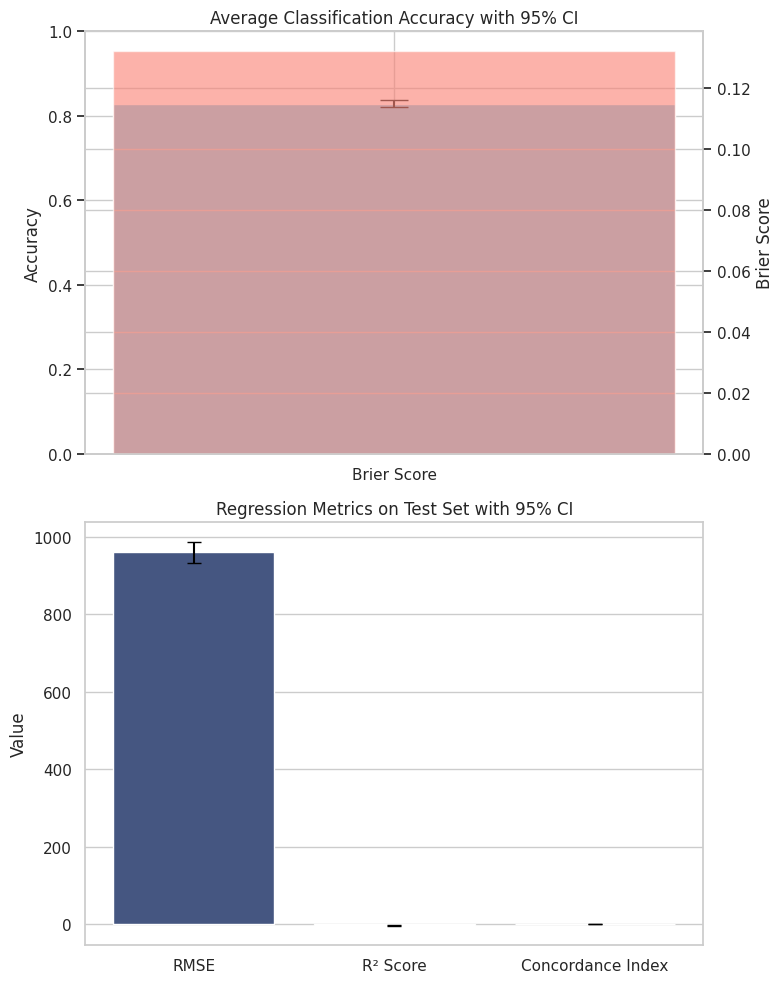

In [62]:
main_pipeline_parallel(base_path, n_splits=5, n_jobs=1)